Elijah Burns <br/>
Phys 434 <br/>
Labs 7 & 8 Double Lab

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from pyuvdata import UVData

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('hera_data.uvh5', 'r')
hf.keys()

<KeysViewHDF5 ['Data', 'Header']>

In [3]:
data = np.array(hf.get('Data'))
print(data)

['flags' 'nsamples' 'visdata']


In [4]:
hf.close()

In [5]:
uv = UVData()
uv.read('hera_data.uvh5')
data = uv.data_array
print('This data array has shape:')
print('(# baselines*times, # spectral windows, # frequencies, # polarizations)')
print(np.shape(data))

This data array has shape:
(# baselines*times, # spectral windows, # frequencies, # polarizations)
(13320, 1, 1536, 1)


**Initial data axes
Just to be clear, your initial dataset should have the following axes:**

**vab  (each cross-power measurement between antennas  a  and  b . This labelled  vab  because the measurements are called 'visibilities'. A complex quantity in Jansky units.)**

**tn  (each time step, seconds units.)**

**f  (each frequency, in MHz)**

In [6]:
pairs =uv.get_antpairs()

**Signal removal
The data contains both sky signal (good) and contamination (bad). To make a background distribution, we really need to remove the sky signal. The sky signal in this data is very steady in time. Most of the sources are distant radio galaxies who's intensity (brightness) is steady over millions of years, and they move slowly across the sky. But our measurements are every ~10 seconds. So we can remove the astrophysical signals by subtracting neighboring time samples. Many of the contaminants have a lot of variability, either because the brightness is quickly fluctuating or they are rapidly moving on the sky. So this procedure will remove most of the sky signal, but much of the contamination we are looking for will remain.**

**After you do this you sould have the following axes:  vab ,  Δt=tn+1−tn , and  f , and we'll use this for the duration. You will also want to ignore when  a=b  measurements (e.g.  vaa  if they exist).**

In [7]:
times = uv.get_times(50,93)
print(times)

for i in range(19):
    times[i] = times[i+1]-times[i]
    
print(times)

[2459122.34005893 2459122.34017078 2459122.34028263 2459122.34039448
 2459122.34050633 2459122.34061817 2459122.34073002 2459122.34084187
 2459122.34095372 2459122.34106557 2459122.34117741 2459122.34128926
 2459122.34140111 2459122.34151296 2459122.34162481 2459122.34173665
 2459122.3418485  2459122.34196035 2459122.3420722  2459122.34218405]
[1.11848116e-04 1.11848116e-04 1.11848116e-04 1.11848116e-04
 1.11848116e-04 1.11848116e-04 1.11848116e-04 1.11848116e-04
 1.11848116e-04 1.11848116e-04 1.11848116e-04 1.11848116e-04
 1.11848116e-04 1.11848116e-04 1.11848116e-04 1.11848116e-04
 1.11848116e-04 1.11848116e-04 1.11848116e-04 2.45912234e+06]


Notes on time values:
f(del_tn,w) = f(tn,w)-f(tn+1,w)

**Waterfall plots
One particularly usefull plot is a waterfall plot (why it is called this is very obscure), a plot of the power  v  vs. time and frequency. The idea is to have a 2D plot showing the magnitude of the visibility  |vab|  versus time and frequency, with all axes labelled and in the appropriate units.**

In [8]:
# Look at the antennas that are contained in the array:
print(sorted(uv.antenna_numbers))
# Pick 2 sample antennas, and get data from that baseline. Note that to get the 'auto-correlations', you can do the 
# same thing, but set antenna1 and antenna2 to be the same value.
antenna1 = 50
antenna2 = 93

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 36, 37, 38, 39, 44, 45, 46, 50, 51, 52, 53, 58, 59, 65, 66, 67, 68, 73, 75, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


Signal Removal: <br/>
The cell below takes the values of power for adjacent time slices and subtracts the value from the next time from the current time. It does this for time slices (1-0) to (20-19) resulting in 19 time slices rather than the original 20 since it is impossible to subtract time slice 21 from 20, since time slice 21 doesn't exist. It also does this for all frequencies. The reasoning for performing this operation is to remove any signals that last for less than 10 seconds, which would be assumed to be man made signal. They would be 10 seconds or less because each time slice lasts for about 10 seconds. Since we are interested in sky signal, we don't want these short, flickering signals, and this subtraction method attempts to remove most of them. This particular cell only performs this operation for antenna pair 50,93. Later, we will perform this operation on all antenna pairs (except for when ant1==ant2).

In [62]:
data = abs(uv.get_data(antenna1,antenna2))
data1 = data[0:19]
#print(abs(data[18]))
#print()
#print(abs(data[17]))
#print()
for i in range(19):
    data1[i] = (data[i+1]-data[i])

#print(data1)

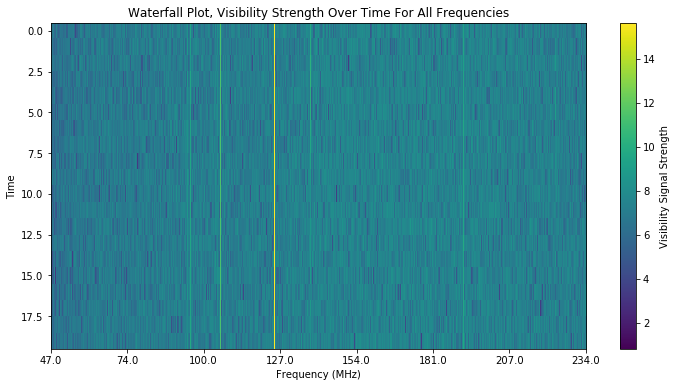

In [63]:
data = abs(uv.get_data(antenna1,antenna2))
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log(np.abs(data)),aspect='auto')
plt.title('Waterfall Plot, Visibility Strength Over Time For All Frequencies')
cbar = fig.colorbar(im)
cbar.set_label('Visibility Signal Strength', rotation = 90)
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)

Waterfall plot Above: <br/>
The waterfall plot above shows the relationship for the magnitude of the power signals vs. the frequency and time. Brighter colors are stronger signals received by the antenna. This plot is the original data, no subtraction has been performed yet so it isn't quite what we are looking for.
<br/>
<br/>
Waterfall plot Below: <br/>
The waterfall plot below shows the same relationship, but now the subtraction has been performed, which has hopefully removed any contamination and left us with only sky-like signal for the (50,93) antenna pair. We see the background is much 'smoother' and most of the bright vertical lines that had shown up in the waterfall plot above are gone as well. We still see a bright line around 127 MHz which could mean that the signal showing up there is consistent in the sky at all times, and is not man-made.

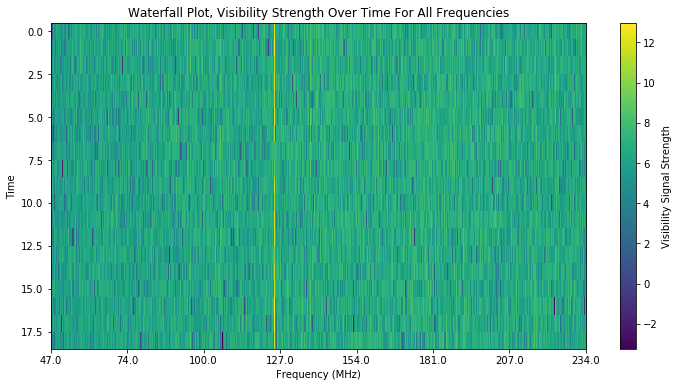

In [64]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log(np.abs(data1)),aspect='auto')
plt.title('Waterfall Plot, Visibility Strength Over Time For All Frequencies')
cbar = fig.colorbar(im)
cbar.set_label('Visibility Signal Strength', rotation = 90)
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)

**Single antenna pair plots
Pick the visibilities from a single antenna pair. Plot both the waterfall and a histogram of the magnitude of the visibility.**

**Comment on why we are histogramming the magnitude. Describe the basic shape.**

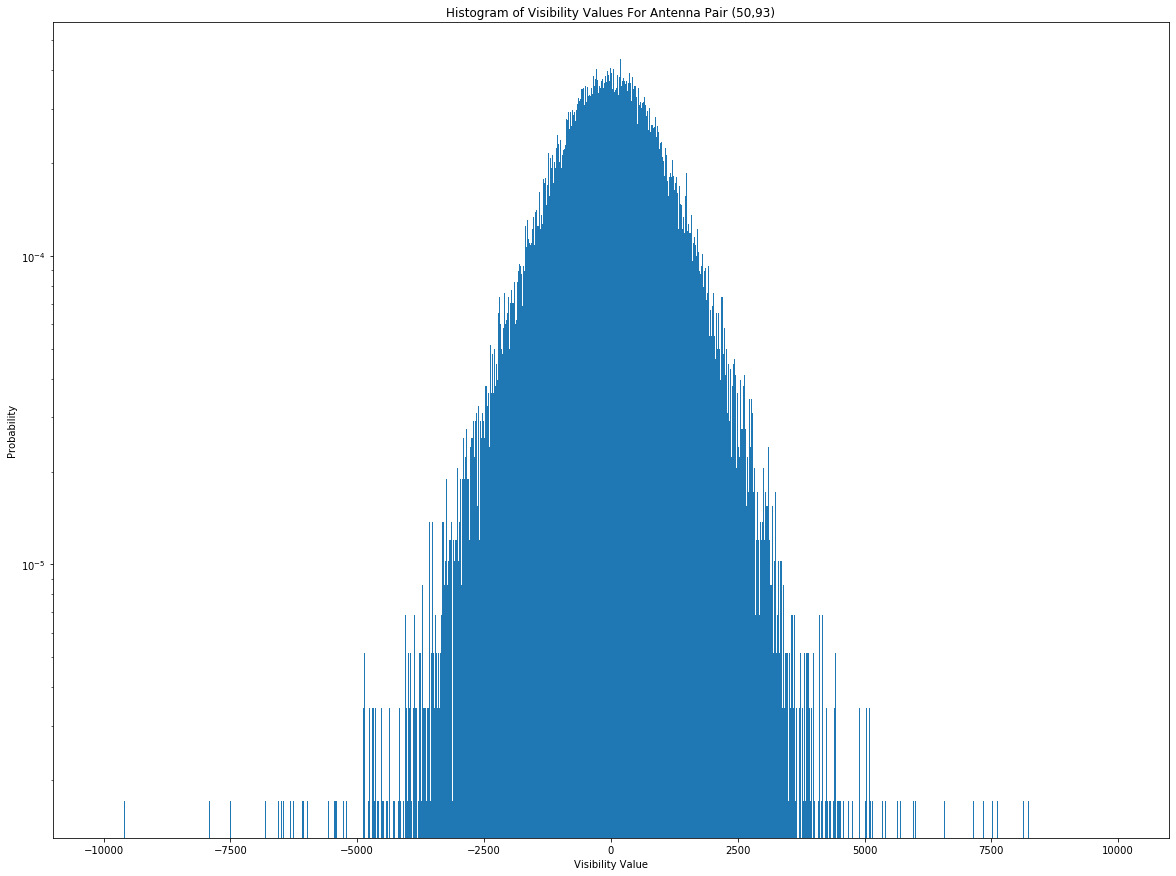

In [65]:
dat1 = []
for i in range(19):
    for j in range(1536):
        dat1.append((data1[i][j]))
#print(max(dat1))


plt.hist(dat1, bins=1000, density = True, range = (-10000,10000))
plt.yscale('log')
plt.ylabel('Probability')
plt.xlabel('Visibility Value')
plt.title('Histogram of Visibility Values For Antenna Pair (50,93)')
plt.show()

We histogram the magnitude of the visibilites because we're interested in the power the antennas receive, which can be determined by taking the absolute value of the complex number of the original visibility value.
We see a Gaussian distribution of the background data. This suggests we have done a decent job of removing any contamination, and that the background sky signal is has no bias and is centered on zero. <br/>
<br/>
Again the waterfall plot for this signle antenna pair (50,93) is in the cell just above.

**Average visibility plots**

**If a signal comes from far away, we will expect to see it in all antenna pairs. So to increase our sensitivity we can average all of the baseline pairs (make sure to not include the  vaa  values). But because the visibilities are complex, we have to be careful. What we really want is the average of the magnitudes  <|v|>ab , where  a  and  b  cover all values  a≠b .**

**Make the associated waterfall and histogram plots, explore and describe.**

**If your distribution is not centered at zero it may be useful to subtract the average value. If you go down this road, explore whether you want to subtract the global average, or an average per frequency or per time.**

In [14]:
total_dat = []
for i in range(666):
    temp = []
    ant1 = pairs[i][0]
    ant2 = pairs[i][1]
    if ant1 == ant2:
        continue
    data = abs(uv.get_data(ant1,ant2))
    temp = data[0:19]
    for j in range(19):
        temp[j] = (data[j+1]-data[j])
    total_dat.append(temp)

In [15]:
total_dat1 = np.average(total_dat, axis=0)

The process being carried out in the two cells above is similar to the subtraction process described earlier in the lab. However, the subtraction is being done to all antenna pairs now, aside from when ant1==ant2, rather than a single antenna pair. After that has been done, the values for the visibilities associated with each time slice and frequency are then averaged from all the antenna pairs. The reason for doing this is to increase the sensitivity, because if we see a signal coming from a source that is very far away, it should hit all of the antenna pairs.

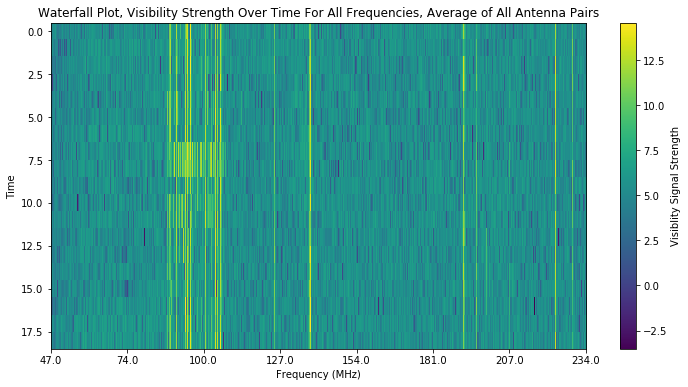

In [66]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log(np.abs(total_dat1)),aspect='auto')
plt.title('Waterfall Plot, Visibility Strength Over Time For All Frequencies, Average of All Antenna Pairs')
cbar = fig.colorbar(im)
cbar.set_label('Visiblity Signal Strength', rotation = 90)
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)

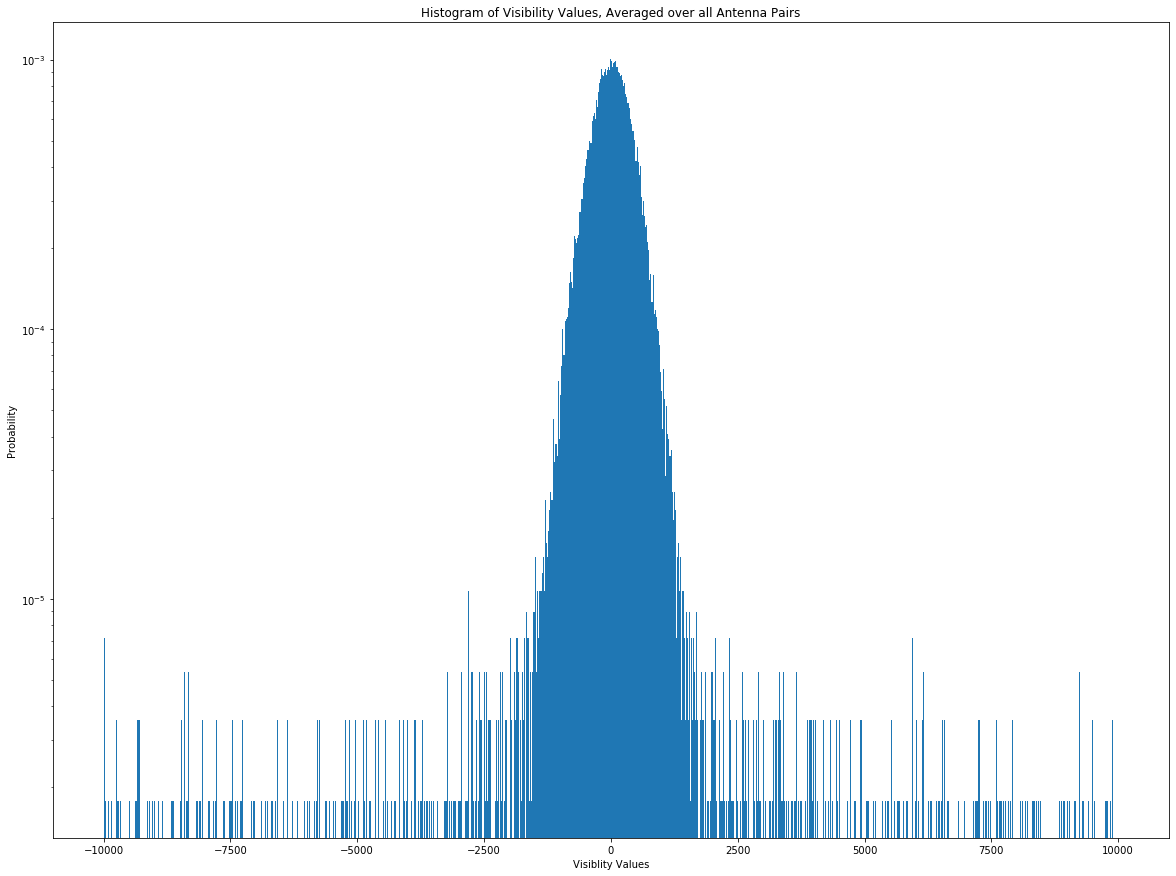

In [74]:
newlist = []
for i in range(19):
    for j in range(1536):
        newlist.append((total_dat1[i][j]))


plt.hist(newlist, bins=1000, density = True, range = (-10000,10000))
plt.title('Histogram of Visibility Values, Averaged over all Antenna Pairs')
plt.ylabel('Probability')
plt.xlabel('Visiblity Values')
plt.yscale('log')
plt.show()

Comments on Waterfall Plot: <br/>
We get a bit of an interesting waterfall plot from averaging the signals from all the antenna pairs. Some of these features will be discussed in the next Feature Exploration section. <br/>
<br/>
Comments on Histogram:
We get another Gaussian distributed histogram, which is to be expected since the distribution for a single antenna pair was Gaussian. This distribution is more narrow though, which is again to be expected since we have averaged many samples together to produce this distribution.

**Feature exploration**

**Describe the features you are seeing as accurately as you can. For some of the data files the following might be helpful https://www.ee.co.za/wp-content/uploads/2015/03/csir-035-02-2015_.jpg**

Waterfall Plot: In the waterfall plot we see some bright vertical lines, but most interestingly we see a large range of frequencies for which these bright vertical lines really stand out. Upon closer inspection of the link above, it appears that the frequency range from about 87 MHz to 108 MHz is reserved for broadcasting. This range corresponds to the region in the waterfall plot where we see the most noise. It is likely that this broadcasting signal is strong enough that all the antennas pick up on it across all times, and that it overpowers any sky-like signal we would see in that region.

**Jackknife plots
You may be seeing features already, but there may be features that are still below the level you can see by eye. For this we will need a jackknife test. The steps to any jackknife test are:**

**a) Come up with a concern (state clearly)**

**b) Identify a data cut, where if the concern is true the contamination should appear in one data set but not the other.**

**c) Calculate the histograms for each dataset, including the error bars on the histogram. Plot the histograms.**

**d) For the actual jackknife, subtract the histograms and see whether they are consistent to within the expected error (note the errors on the difference are not identical to the errors on each histogram individually.).**

**Perform a jackknife test or two. Clearly describe whether the jackknife passed (statistically identical) or failed (there is a difference), and what this means about your initial concern in part a).**

Jackknife Part a): <br/>
We see in the average visibility data there appears to be some contamination in the 80 MHz to 110 MHz region. It is a region where there is a lot of signal coming through, the concern being we do not believe it should be there because we believe the signal we are receiving is broadcasting signal, which would be contaminating the data. <br/>
<br/>
Jackknife Part b): <br/>
We will cut all visibility values in this region since it seems likely that we will only be picking up broadcasting signals in this frequency region, which we are not interested in.

In [18]:
#freq indices: 271, 517

#making the cuts 

cut_total_dat = []
for i in range(666):
    temp1 = []
    ant1 = pairs[i][0]
    ant2 = pairs[i][1]
    if ant1 == ant2:
        continue
    data5 = abs(uv.get_data(ant1,ant2))
    data5[0:20,271:517] = 0
    temp1 = data5[0:19]
    for j in range(19):
        temp1[j] = (data5[j+1]-data5[j])
    cut_total_dat.append(temp1)

In [19]:
cut_total_dat1 = np.average(cut_total_dat, axis=0)

divide by zero encountered in log


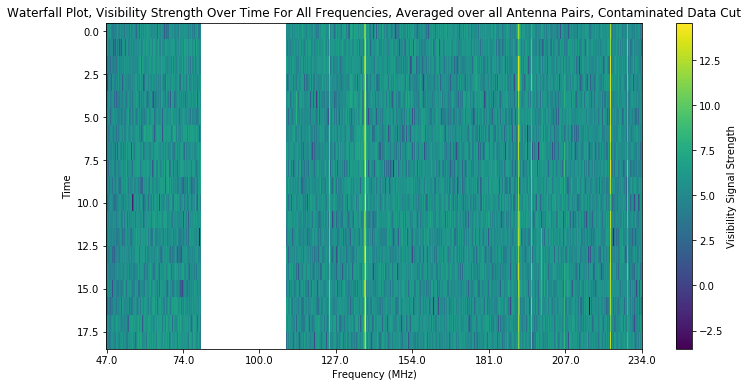

In [69]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log(np.abs(cut_total_dat1)),aspect='auto')
plt.title('Waterfall Plot, Visibility Strength Over Time For All Frequencies, Averaged over all Antenna Pairs, Contaminated Data Cut')
cbar = fig.colorbar(im)
cbar.set_label('Visibility Signal Strength', rotation = 90)
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)

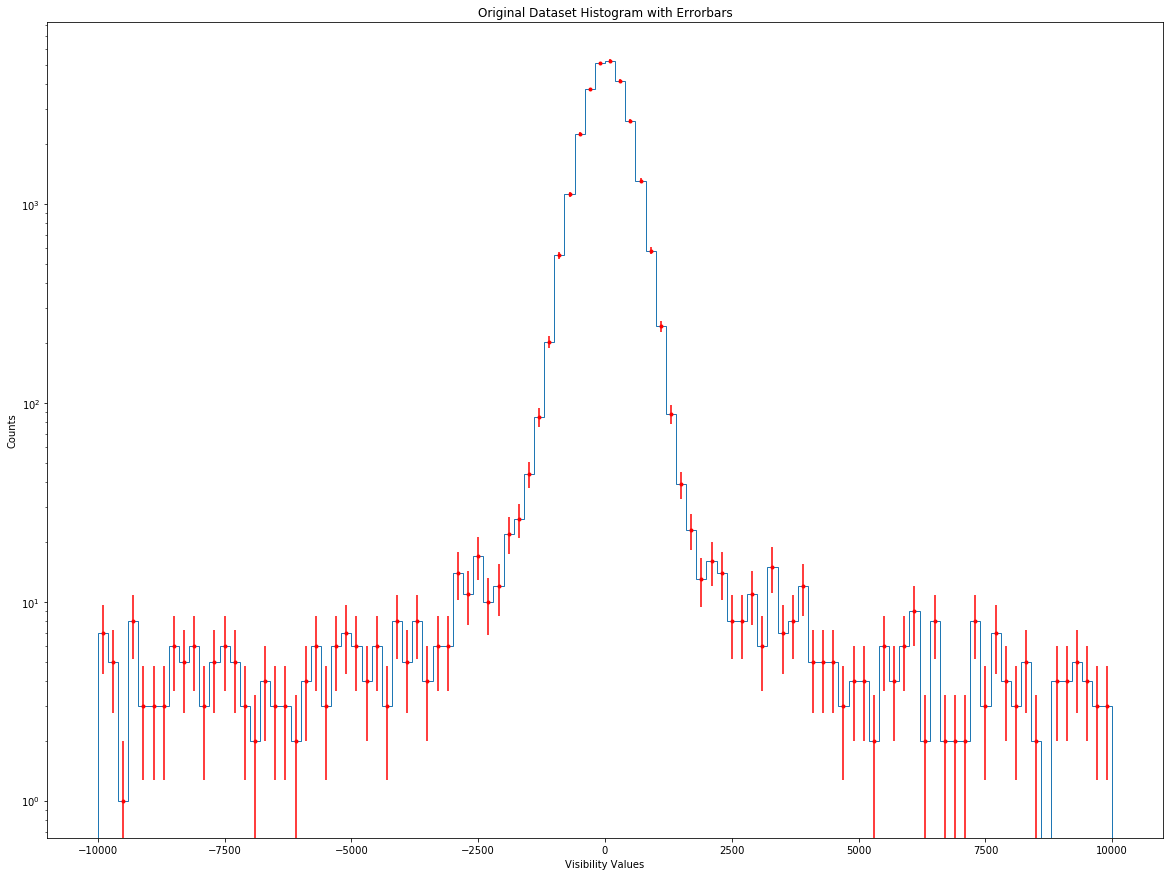

In [70]:
entries1, edges1, _1 = plt.hist(newlist, bins = 100, density = False, range = (-10000,10000), histtype = 'step')
bincenters1 = .5 * (edges1[:-1] + edges1[1:])
plt.errorbar(bincenters1, entries1, yerr=np.sqrt(entries1),fmt='r.')
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Visibility Values')
plt.title('Original Dataset Histogram with Errorbars')
plt.show()

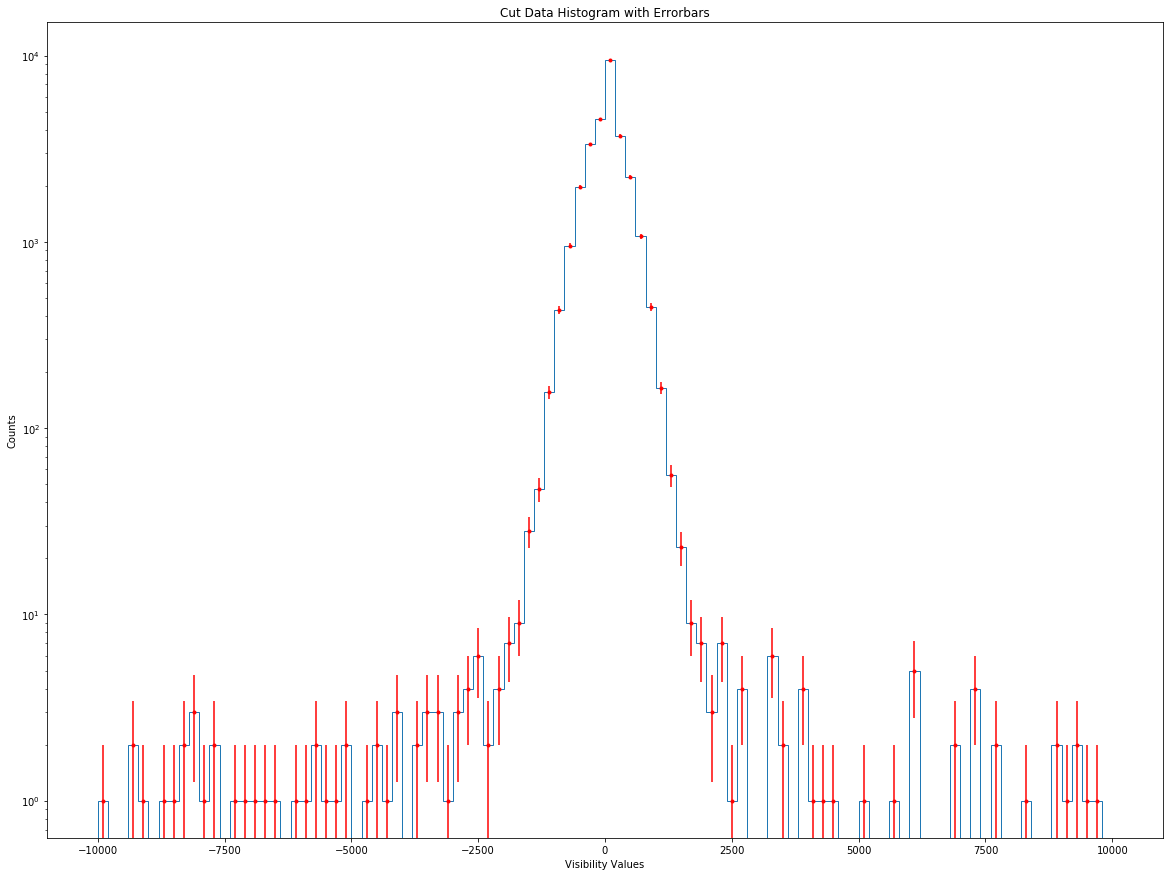

In [71]:
newlist_cut = []
for i in range(19):
    for j in range(1536):
        newlist_cut.append((cut_total_dat1[i][j]))


entries, edges, _ = plt.hist(newlist_cut, bins=100, density = False, range = (-10000,10000), histtype = 'step')
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')
plt.yscale('log')
plt.title('Cut Data Histogram with Errorbars')
plt.ylabel('Counts')
plt.xlabel('Visibility Values')
plt.show()


In [24]:
comb_cut = []
for i in range(len(newlist)):
    comb_cut.append((newlist[i])-(newlist_cut[i]))

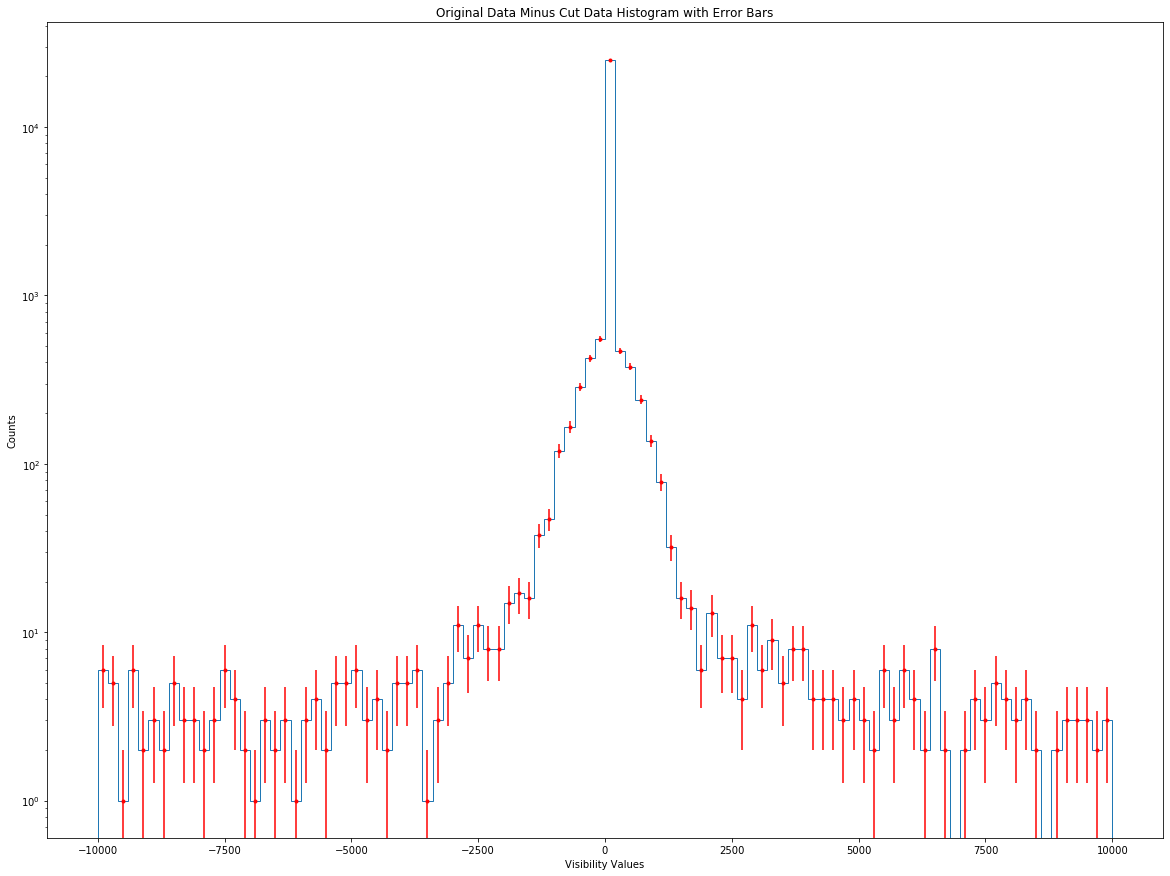

In [72]:
entries2, edges2, _2 = plt.hist(comb_cut, bins=100, density = False, range = (-10000,10000), histtype = 'step')
bin_centers2 = 0.5 * (edges2[:-1] + edges2[1:])
plt.errorbar(bin_centers2, entries2, yerr=np.sqrt(entries2), fmt='r.')
plt.yscale('log')
plt.title('Original Data Minus Cut Data Histogram with Error Bars')
plt.ylabel('Counts')
plt.xlabel('Visibility Values')
plt.show()

Based on the histogram of the original data set minus the data set without the contamination (cut data), we see that there is a statistical difference, in other words they are not identical, so the Jackknife test failed. This means we do have to consider the concern that was raised in part a.), and that removing the data in the 80-110 MHz range would probably be a good idea in order to minimize the amount of bad data the antennas pick up.

**Data cuts**

**Based on your identified features and jackknife tests, come up with a set of cuts to remove contaminated data.**

**After your cuts, recalculate the average visibility histogram, and compare it to what you had before.**

**If you had a candidate signal in this space, what is the significance of your detection before and after removing the contamination? Discuss in detail. This is the key step in the entire course, so really think about it. Normally we'd want to include as much data as possible to increase sensitivity, but here we are choosing to remove data. Why?**

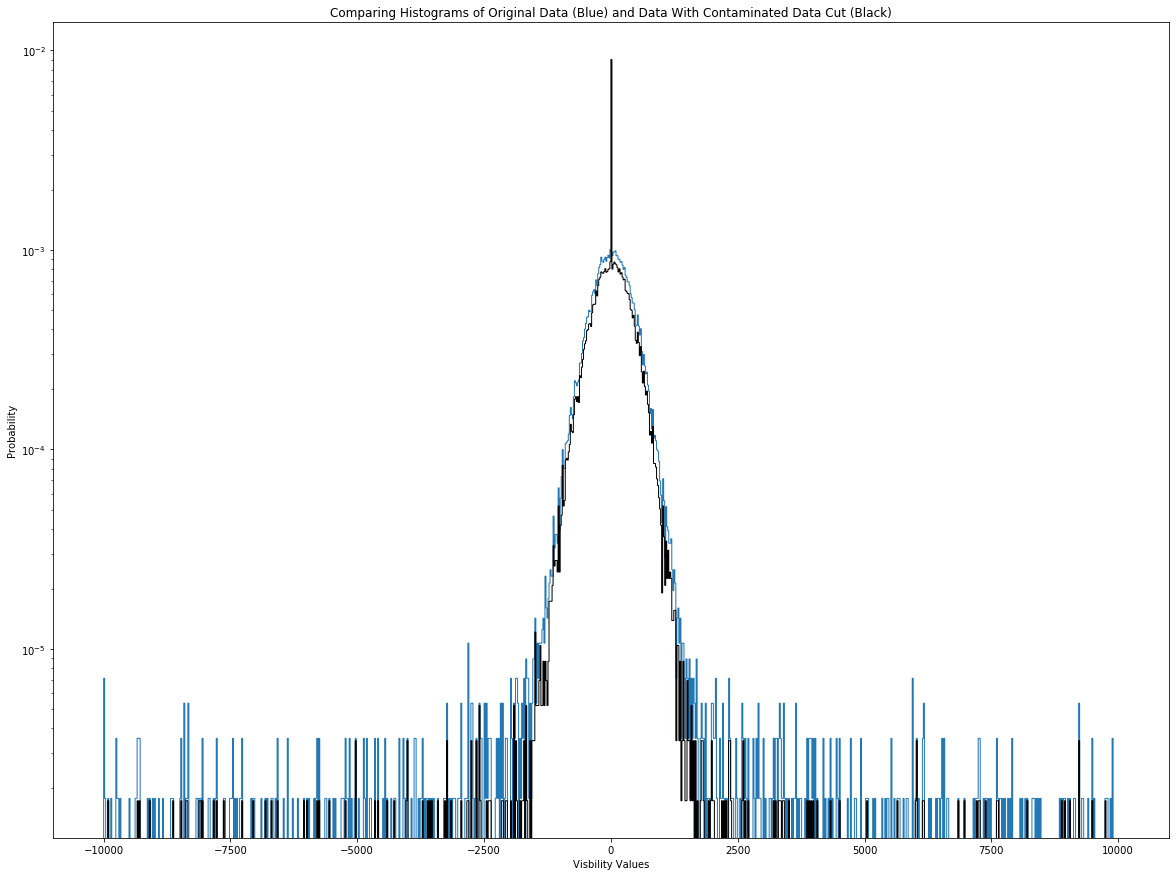

In [75]:
#histogram before removal
plt.hist(newlist, bins=1000, density = True, range = (-10000,10000), histtype = 'step')
plt.yscale('log')
#plt.show()

#histogram after removal
plt.hist(newlist_cut, bins=1000, density = True, range = (-10000,10000), color = 'k', histtype = 'step')
plt.yscale('log')
plt.ylabel('Probability')
plt.xlabel('Visbility Values')
plt.title('Comparing Histograms of Original Data (Blue) and Data With Contaminated Data Cut (Black)')
plt.show()

In [34]:
prob5sigma = 1-1/(3.5e6)
signif = stats.norm.ppf(prob5sigma, loc = 0, scale = 1900)

cut_signif = stats.norm.ppf(prob5sigma, loc = 0, scale = 1500)

print('Pre-Cut 5 sigma location',signif)
print()
print()
print('Post-Cut 5 sigma location',cut_signif)

Pre-Cut 5 sigma location 9501.199726367724


Post-Cut 5 sigma location 7500.947152395572


Before the cut, the 5 sigma significance location of a signal was: 9501.199726367724 Jansky Units

After the cut, the 5 sigma significance location of a signal was: 7500.947152395572 Jansky Units
<br/>
<br/>
In this scenario, we wanted to remove data because it was contiminating the rest of the dataset. In other words, it was bad data that would've skewed our results because it was not sky-like signal. The contaminating data would overpower anything signal like data, giving less sensative results, and because of this the signal received in the contaminated data set would have to be stronger than in a non-contaminated data set in order to be considered significant. By making the data cuts, the signal received does not have to be as strong in order to be considered signficant because it does not have to 'compete' against the signal that was seen in the 80-110 MHz range, which was likely a man-made broadcasting signal.